In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
data_frame = pd.read_csv('phishing_site_urls.csv')

# Feature Engineering
data_frame['num_dots'] = data_frame['URL'].apply(lambda x: min(str(x).count('.'), 4))  # Limit the number of dots to 4
data_frame['url_len'] = data_frame['URL'].apply(lambda x: len(str(x)))

# Define a threshold for URL length
threshold_length = 70
data_frame['is_bad_url'] = data_frame['url_len'] > threshold_length

# Separate features and labels
X = data_frame[['num_dots', 'url_len']]
y = data_frame['is_bad_url']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Convert labels to one-hot encoding
y_train_one_hot = F.one_hot(y_train_tensor, num_classes=2)
y_test_one_hot = F.one_hot(y_test_tensor, num_classes=2)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(X_test_tensor, y_test_one_hot)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class PhishingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PhishingLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

# Initialize the LSTM model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = 2  # assuming binary classification

lstm_model = PhishingLSTM(input_size, hidden_size, num_layers, output_size)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs_lstm = 20

for epoch in range(epochs_lstm):
    lstm_model.train()
    for inputs, labels in train_loader:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs.unsqueeze(1))
        loss = criterion_lstm(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer_lstm.step()

# Get the last hidden state from the trained LSTM model
with torch.no_grad():
    lstm_model.eval()
    lstm_hidden_states = []
    for inputs, _ in test_loader:
        outputs = lstm_model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        lstm_hidden_states.append(outputs)

lstm_hidden_states = torch.cat(lstm_hidden_states, dim=0)

# Feature vector from Assignment 2
# Assuming you have a feature vector with 10 dimensions
feature_vector = torch.randn((lstm_hidden_states.shape[0], 10), dtype=torch.float32)

# Combine LSTM output and feature vector
combined_features = torch.cat([lstm_hidden_states, feature_vector], dim=1)

# Define a neural network for further processing
class CombinedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CombinedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the combined model
input_dim_combined = combined_features.shape[1]
hidden_dim_combined = 32
output_dim_combined = 2

combined_model = CombinedModel(input_dim_combined, hidden_dim_combined, output_dim_combined)
criterion_combined = nn.CrossEntropyLoss()
optimizer_combined = optim.Adam(combined_model.parameters(), lr=0.001)

# Add these lists at the beginning to store training loss and accuracy
train_losses_lstm = []
train_losses_combined = []
accuracy_over_epochs = []

# Modify the training loop for the LSTM model to store the average loss
epochs_lstm = 20
for epoch in range(epochs_lstm):
    lstm_model.train()
    total_loss_lstm = 0.0
    for inputs, labels in train_loader:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs.unsqueeze(1))
        loss = criterion_lstm(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer_lstm.step()
        total_loss_lstm += loss.item()
    average_loss_lstm = total_loss_lstm / len(train_loader)
    train_losses_lstm.append(average_loss_lstm)  # Store the average loss

# Modify the training loop for the combined model to store the loss and accuracy
epochs_combined = 20
for epoch in range(epochs_combined):
    combined_model.train()
    optimizer_combined.zero_grad()
    outputs_combined = combined_model(combined_features)
    loss_combined = criterion_combined(outputs_combined, torch.argmax(y_test_one_hot, dim=1))
    loss_combined.backward()
    optimizer_combined.step()
    train_losses_combined.append(loss_combined.item())  # Store the loss

    # Evaluate accuracy during training for the combined model
    combined_model.eval()
    with torch.no_grad():
        test_outputs_combined = combined_model(combined_features)
        _, predicted_combined = torch.max(test_outputs_combined, 1)
        accuracy_combined = torch.sum(predicted_combined == torch.argmax(y_test_one_hot, dim=1)).item() / len(y_test_tensor)
        accuracy_over_epochs.append(accuracy_combined)  # Store the accuracy

        print(f"Combined Model Accuracy: {accuracy_combined * 100:.2f}%")


Combined Model Accuracy: 83.29%
Combined Model Accuracy: 83.38%
Combined Model Accuracy: 83.76%
Combined Model Accuracy: 85.68%
Combined Model Accuracy: 91.15%
Combined Model Accuracy: 96.46%
Combined Model Accuracy: 98.65%
Combined Model Accuracy: 99.41%
Combined Model Accuracy: 99.68%
Combined Model Accuracy: 99.80%
Combined Model Accuracy: 99.87%
Combined Model Accuracy: 99.91%
Combined Model Accuracy: 99.94%
Combined Model Accuracy: 99.96%
Combined Model Accuracy: 99.97%
Combined Model Accuracy: 99.99%
Combined Model Accuracy: 99.99%
Combined Model Accuracy: 99.99%
Combined Model Accuracy: 100.00%
Combined Model Accuracy: 100.00%


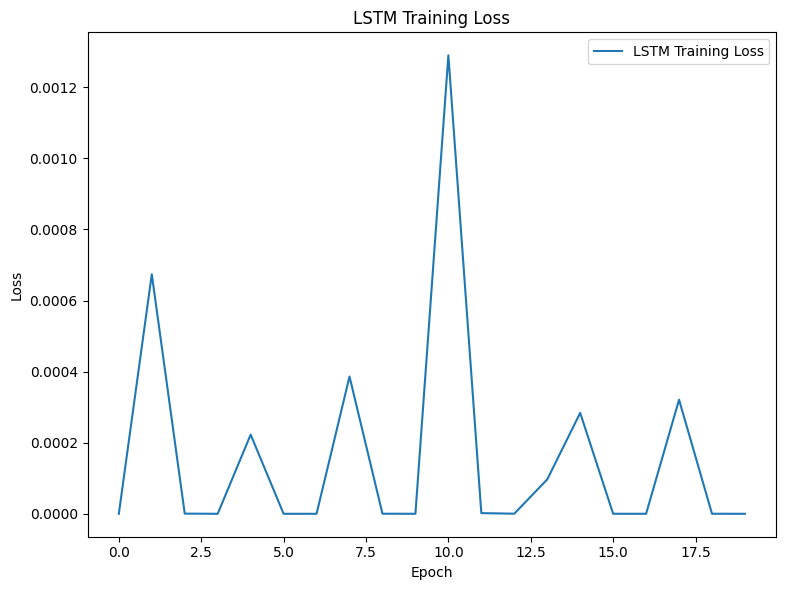

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss for LSTM and combined models
plt.figure(figsize=(15, 6))

# Plot training loss for LSTM model
plt.subplot(1, 2, 1)
plt.plot(train_losses_lstm, label='LSTM Training Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()

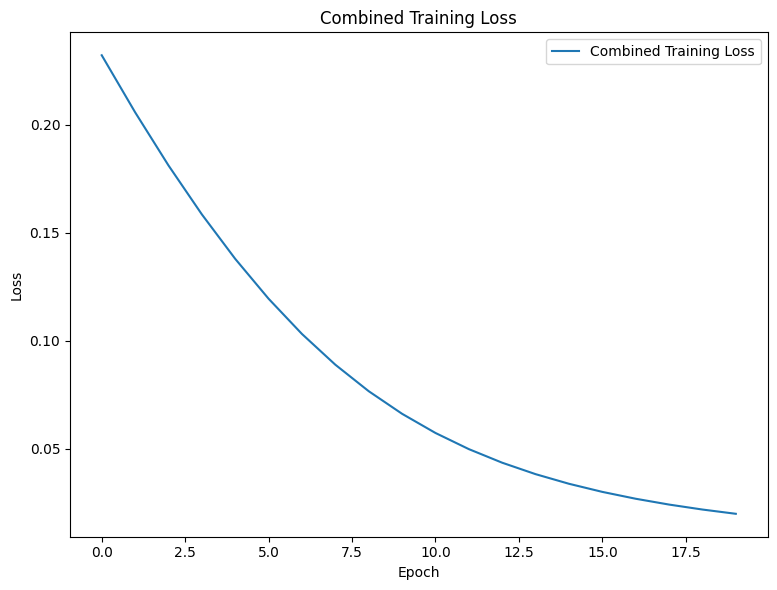

In [ ]:
# Plot training loss for the combined model
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
plt.plot(train_losses_combined, label='Combined Training Loss')
plt.title('Combined Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()

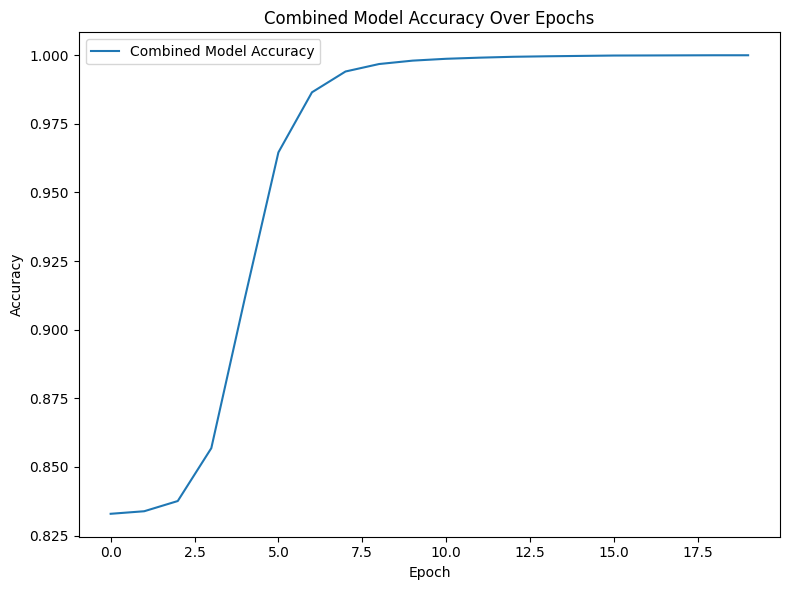

In [ ]:
# Plot accuracy over epochs for the combined model
plt.figure(figsize=(8, 6))
plt.plot(accuracy_over_epochs, label='Combined Model Accuracy')
plt.title('Combined Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()